# <center> Homework 8 Solutions </center>

# Exercise 1
### Part 1
Computing the gradient is easiest if we rewrite the objective function and then compute the partial derivative of the first term with respect to one element of $\alpha$ at a time. Observe that
\begin{align*}
F(\alpha) &:= \frac{1}{n} \sum_{i=1}^n \left(\max(0, 1 - y_i (K \alpha)_i)\right)^2 \; + \lambda \alpha^{T} K \alpha \\
&= \frac{1}{n} \sum_{i=1}^n \left(\max\left(0, 1 - y_i \sum_{j=1}^n K_{ij}\alpha_j\right)\right)^2 \; + \lambda \alpha^{T} K \alpha.
\end{align*}
Now let's differentiate the first term with respect to $\alpha_1$. To do this, we can apply the chain rule:
$$\frac{\partial}{\partial \alpha}\left\{\frac{1}{n} \sum_{i=1}^n \left(\max(0, 1 - y_i (K \alpha)_i)\right)^2\right\} = -\frac{2}{n} \sum_{i=1}^n y_iK_{i1} \max\left(0, 1 - y_i \sum_{j=1}^n K_{ij}\alpha_j\right).$$
The partial derivatives with respect to the other $\alpha_i$'s is similar. Therefore, the gradient of $F$ is given by 
\begin{align*}
\nabla F(\alpha) &= -\frac{2}{n} \sum_{i=1}^n y_iK_{i,\cdot} \max\left(0, 1 - y_i \sum_{j=1}^n K_{ij}\alpha_j\right) + 2\lambda K\alpha.
\end{align*}


### Other parts
Here I am only using a small subset of MNIST so that it runs faster. You are welcome to scale it up to use a larger fraction of the data.

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import scipy.linalg
from sklearn.datasets import fetch_mldata
import sklearn.metrics
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.svm


# Part 2: Compute K
def computegram(x, kernel, params):
    gram = kernel(x, x, params)
    return gram


def poly(x1, x2, params):
    return (x1.dot(x2.T) + 1)**params['power']


def rbf(x1, x2, params):
    if x2.ndim == 2:
        return np.exp(-np.linalg.norm(np.subtract(x1[:, :, np.newaxis], x2[:, :, np.newaxis].T), axis=1)**2/params['sigma']**2)
    else:
        return np.exp(-np.linalg.norm(np.subtract(x1, x2), axis=1) ** 2 / params['sigma'] ** 2)


# Part 3: Compute vector of kernel evaluations
def kerneleval(x, x_new, kernel, params):
    keval = kernel(x, x_new, params)
    return keval


# Part 4: Load and standardize the MNIST dataset
def load_data():
    mnist = fetch_mldata('MNIST original')
    x_all = mnist.data
    y_all = mnist.target
    one_two_idxs = np.concatenate((np.where(y_all == 1)[0], np.where(y_all == 2)[0]))
    x = x_all[one_two_idxs]
    y = (y_all[one_two_idxs]-1)*2 - 1
    print('Number of examples:', x.shape[0])

    return x, y


def split_standardize_data(x, y):
    x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y, train_size=0.01, test_size=0.02, random_state=0)
    x_valid, x_test, y_valid, y_test = sklearn.model_selection.train_test_split(x_test, y_test, train_size=0.5, test_size=0.5, random_state=0)
    scaler = sklearn.preprocessing.StandardScaler()
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_valid = scaler.transform(x_valid)
    x_test = scaler.transform(x_test)

    return x_train, x_valid, x_test, y_train, y_valid, y_test


# Part 5: Implementation of fast gradient to train the kernel SVM
def computegrad(alpha, lambduh, K, y):
    K_alpha = np.dot(K, alpha)
    grad = -2 / len(y) * np.sum(
        y[:, np.newaxis] * K * np.max((np.zeros_like(y), 1 - y * K_alpha), axis=0)[:, np.newaxis],
        axis=0) + 2 * lambduh * K_alpha
    return grad


def objective(alpha, lambduh, K, y):
    K_alpha = np.dot(K, alpha)
    return 1 / len(y) * np.sum(np.max((np.zeros_like(y), 1 - y * K_alpha), axis=0) ** 2) + lambduh * alpha.dot(K_alpha)


def bt_line_search(alpha, lambduh, K, y, eta=1, alpha_bt=0.5, betaparam=0.1, maxiter=1000):
    grad_alpha = computegrad(alpha, lambduh, K, y)
    norm_grad_alpha = np.linalg.norm(grad_alpha)
    found_eta = 0
    iter = 0
    obj_now = objective(alpha, lambduh, K, y)
    while found_eta == 0 and iter < maxiter:
        obj_next = objective(alpha - eta * grad_alpha, lambduh, K, y)
        if obj_next < obj_now - alpha_bt * eta * norm_grad_alpha ** 2:
            found_eta = 1
        elif iter == maxiter - 1:
            print('Warning: Max number of iterations of backtracking line search reached')
            break
        else:
            eta *= betaparam
            iter += 1
    return eta


def graddescent(alpha_init, lambduh, K, y, eta_init, maxiter):
    alpha = alpha_init
    eta = eta_init
    grad_alpha = computegrad(alpha, lambduh, K, y)
    alpha_vals = alpha
    iter = 0
    while iter < maxiter:
        eta = bt_line_search(alpha, lambduh, K, y, eta=eta)
        alpha = alpha - eta * grad_alpha
        grad_alpha = computegrad(alpha, lambduh, K, y)
        iter += 1
        if iter % 1000 == 0:
            alpha_vals = np.vstack((alpha_vals, alpha))
            print('Gradient descent iteration', iter)
    return alpha_vals


def fastgradalgo(alpha_init, theta_init, lambduh, K, y, eta_init, maxiter, x_train, x_valid, y_valid, kernel):
    alpha = alpha_init
    theta = theta_init
    eta = eta_init
    grad_theta = computegrad(theta, lambduh, K, y)
    alpha_vals = alpha
    iter = 0
    while iter < maxiter:
        eta = bt_line_search(theta, lambduh, K, y, eta=eta)
        alpha_new = theta - eta * grad_theta
        theta = alpha_new + iter / (iter + 3) * (alpha_new - alpha)
        grad_theta = computegrad(theta, lambduh, K, y)
        alpha = alpha_new
        iter += 1
        if iter % 10 == 0:
            alpha_vals = np.vstack((alpha_vals, alpha_new))
    return alpha_vals


def misclassification_error(alpha, x_train, x_test, y_test, kernel, kernel_params):
    n_test = len(y_test)
    y_pred = np.zeros(n_test)
    for i in range(n_test):
        y_pred[i] = np.dot(kerneleval(x_train, x_test[i, :], kernel, kernel_params), alpha) > 0
    y_pred = y_pred* 2 - 1
    return np.mean(y_pred != y_test)


def objective_plot(alphas, lambduh, K, y, save_file=''):
    num_points = np.size(alphas, 0)
    objs = np.zeros(num_points)
    for i in range(0, num_points):
        objs[i] = objective(alphas[i, :], lambduh, K, y)
    fig, ax = plt.subplots()
    ax.plot(np.array(range(num_points))*10, objs, c='red')
    plt.xlabel('Iteration')
    plt.ylabel('Objective value')
    plt.title('Objective value vs. iteration when lambda=' + str(lambduh))
    if not save_file:
        plt.show()
    else:
        plt.savefig(save_file)


# Part 6: Train the kernel SVM with the squared hinge loss and polynomial kernel of order 7
def cross_validate(K, y_train, maxiter, x_train, x_valid, y_valid, kernel, lambda_max):
    lambduh = lambda_max
    best_error = 1
    best_lambda = lambduh
    n = np.size(K, 0)
    for i in range(10):
        alpha_init = np.zeros(n)
        theta_init = np.zeros(n)
        eta_init = 1 / scipy.linalg.eigh(2 / len(y_train) * np.dot(K, K) + 2 * lambduh * K, eigvals=(n - 1, n - 1),
                                         eigvals_only=True)[0]
        alphas = fastgradalgo(alpha_init, theta_init, lambduh, K, y_train, eta_init, maxiter, x_train, x_valid,
                                 y_valid, kernel)
        error = misclassification_error(alphas[-1,:], x_train, x_valid, y_valid, kernel, kernel_params)
        if error < best_error:
            best_lambda = lambduh
            best_error = error
        lambduh /= 10
    print('Optimal lambda:', best_lambda)
    return best_lambda


def get_data(kernel, kernel_params, save_data_file):
    # Check if data exists. If not, get it.
    if not os.path.exists(save_data_file):
        x, y = load_data()
        x_train, x_valid, x_test, y_train, y_valid, y_test = split_standardize_data(x, y)
        # Pre-compute the gram matrix
        print('Computing the gram matrix...')
        K = computegram(x_train, kernel, kernel_params)
        # Save the above things so if we re-run this we don't need to recompute them
        with open(save_data_file, 'wb') as f:
            pickle.dump([x_train, x_valid, x_test, y_train, y_valid, y_test, K], f)
    else:
        with open(save_data_file, 'rb') as f:
            x_train, x_valid, x_test, y_train, y_valid, y_test, K = pickle.load(f)
    return x_train, x_valid, x_test, y_train, y_valid, y_test, K


def train_svm(kernel, kernel_params, save_data_file, maxiter=10000, lambda_max=10**5):
    # Read in the data
    x_train, x_valid, x_test, y_train, y_valid, y_test, K = get_data(kernel, kernel_params, save_data_file)
    # Perform cross-validation to pick the best lambda
    best_lambda = cross_validate(K, y_train, maxiter, x_train, x_valid, y_valid, kernel, lambda_max)
    # Initialize things
    n, d = x_train.shape
    print('Number of training examples: ', n)
    alpha_init = np.zeros(n)
    theta_init = np.zeros(n)
    eta_init = 1 / scipy.linalg.eigh(2 / len(y_train) * np.dot(K, K) + 2 * best_lambda * K, eigvals=(n - 1, n - 1),
                                     eigvals_only=True)[0]
    # Run the algorithm with the optimal lambda
    print('Running fast gradient...')
    alphas = fastgradalgo(alpha_init, theta_init, best_lambda, K, y_train, eta_init, maxiter, x_train, x_valid, y_valid, kernel)
    print('Optimal alphas:', alphas[-1, :])
    objective_plot(alphas, best_lambda, K, y_train, save_file='')
    print('Misclassification error when lambda=', best_lambda, ':', misclassification_error(alphas[-1, :], x_train, x_test, y_test, kernel, kernel_params))

Number of examples: 14867
Computing the gram matrix...


/home/corinne/py3env/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


Optimal lambda: 0.001
Number of training examples:  148
Running fast gradient...
Optimal alphas: [ 0.87813357  0.87813242 -0.65818685  0.87811376 -0.21329908 -0.15456189
 -0.14138288  0.01801342  0.59691788 -0.09153826 -0.04616838  0.87777862
  0.79163852  0.9911319   0.86066852  0.86346198  0.87010123  0.87467946
 -0.10516602  0.87805532  0.87814837 -0.1939581   0.8789449  -0.34431883
  0.87812899  0.87814347 -0.02418387  0.87803482 -0.03699453 -0.0938437
  0.82495053  0.87813357 -0.36821989  0.87062151  0.87808304 -0.14319768
 -0.21569659 -0.36990903  0.85823089  0.84295783 -0.02073174 -0.04510018
 -0.04825503 -0.38426548 -0.25370275 -0.47248027  0.87185629 -0.53195604
 -0.10856182  0.87238334 -0.27603593  0.87803393 -0.02664931 -0.41218125
  0.75765457  0.87145263 -0.08819207  0.8240185   0.87478507  0.87799253
 -0.03634321  0.87813356 -0.21539042  0.04920462 -0.75402372  0.87447469
  0.85580431  0.83297582  0.92144682 -0.73928246 -0.06547907  0.8781273
 -0.01163401 -0.00507318 -0.1

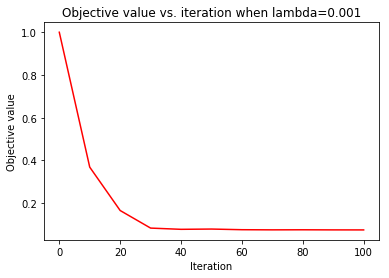

Misclassification error when lambda= 0.001 : 0.0872483221477


In [15]:
kernel_params = {'sigma': 10}
train_svm(rbf, kernel_params, 'data_rbf10.pickle', maxiter=100, lambda_max=10**3)

Optimal lambda: 100.0
Number of training examples:  148
Running fast gradient...
Optimal alphas: [  5.75379330e-11   4.51727137e-09  -4.17220829e-08   4.97916510e-11
  -1.74083576e-08  -1.57115507e-08  -2.03065695e-08  -1.52402045e-08
   5.50613737e-08  -4.69999529e-08  -1.38774977e-08   6.24746040e-09
   2.20739046e-08   1.29852324e-07   1.84494085e-08   3.10365938e-08
   4.31789545e-08   6.71863869e-09  -3.48262656e-08  -1.19800796e-10
   8.90466332e-10  -3.26244176e-08   3.57555227e-09  -2.62125637e-08
   1.17880897e-09   1.37633213e-09  -2.27660192e-08   6.66092039e-10
  -3.59791027e-08  -2.20264333e-08   1.18492228e-08   1.41428997e-10
  -2.08677689e-08   6.81621398e-09   6.74003199e-10  -3.57327497e-08
  -2.94694598e-08  -1.46897506e-08   1.92685735e-08   4.95293474e-08
  -1.90953210e-08  -1.33123470e-08  -1.29018164e-08  -1.72344959e-08
  -7.30894812e-08  -1.40328517e-08   5.04585562e-10  -1.61512021e-08
  -1.86749506e-08   1.66333858e-08  -1.64485751e-08   2.72802561e-09
  -2.1

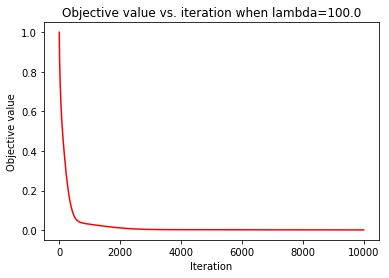

Misclassification error when lambda= 100.0 : 0.0402684563758


In [16]:
kernel_params = {'power': 3}
train_svm(poly, kernel_params, 'data_poly3.pickle')

Number of examples: 14867
Computing the gram matrix...


/home/corinne/py3env/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


Optimal lambda: 100000
Number of training examples:  148
Running fast gradient...
Optimal alphas: [  4.47099211e-24   9.85847622e-22  -9.03649392e-23   5.55896254e-22
  -6.69965317e-24  -1.41519774e-22  -2.43510196e-24  -1.01951980e-23
   8.73315233e-23  -1.54285928e-24  -3.75329161e-24   6.32772698e-21
   1.14608398e-22   5.12191686e-24   1.87010131e-21   5.88257700e-21
   1.17375442e-20   4.92153207e-21  -3.71246795e-24   8.76822592e-22
   7.60652675e-22  -3.25590111e-24   9.69992992e-21  -2.42819182e-23
   6.16851371e-22   3.33724662e-21  -4.68380886e-24   9.97248822e-22
  -3.52734255e-24  -1.41351675e-24   2.42938068e-22   1.72701165e-23
  -3.42930393e-23   3.27342711e-21   1.86974342e-21  -2.47665269e-24
  -1.63765703e-24  -2.13630829e-23   4.29488658e-22   1.84382949e-21
  -1.76816845e-24  -1.48075624e-23  -3.33396823e-24  -1.12862077e-23
  -6.66474780e-25  -1.65242901e-22   9.01925943e-21  -7.76156853e-23
  -3.28926544e-23   8.44200016e-21  -4.30608949e-23   6.01995371e-21
  -5.

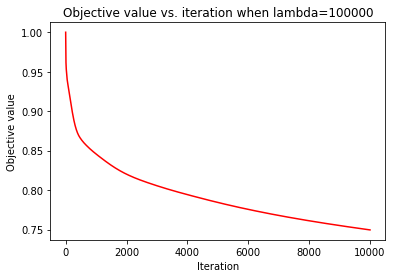

Misclassification error when lambda= 100000 : 0.0335570469799


In [17]:
kernel_params = {'power': 7}
train_svm(poly, kernel_params, 'data_poly7.pickle')

You can see that it hasn't converged, but if you look at the misclassification error on the validation set, it is pretty much unchanging after fewer than 10000 iterations.